# **StaticContentDetector - Logistic Regression**

## Prerequisites

In [ ]:
import json
import csv
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve

## Extract Features

In [ ]:
def extract_static_features_to_csv(json_path, csv_path):
    with open(json_path, 'r', encoding='utf-8') as infile:
        file_content = infile.read()

        try:
            data = json.loads(file_content)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
            print(f"Problematic content around error location:\n{file_content[e.pos - 50:e.pos + 50]}")
            return

    with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        header = [f"feature_{i}" for i in range(6)] + ["label"]
        writer.writerow(header)

        for entry in data:
            features = entry.get("staticContentFeatures", [0] * 6)
            label = entry.get("label", "Error")
            writer.writerow(features + [label])


In [ ]:
json_file_path = "/content/results.json"
csv_output_path = "content_features_regression.csv"
extract_static_features_to_csv(json_file_path, csv_output_path)

## Features observation and Cleanup

In [ ]:
df = pd.read_csv("content_features_regression.csv")
df.label.value_counts()

,count
label,
benign,40504
phishing,24335
Error,5158


### Cleanup

In [ ]:
# remove rows with error label
df = df[df['label'] != 'Error']

# map labels to 0 and 1
df['label'] = df['label'].map({'phishing': 1, 'benign': 0})
X = df[[f"feature_{i}" for i in range(0,6)]]
y = df["label"]

y.value_counts()

,count
label,
0,40504
1,24335


### Correlation

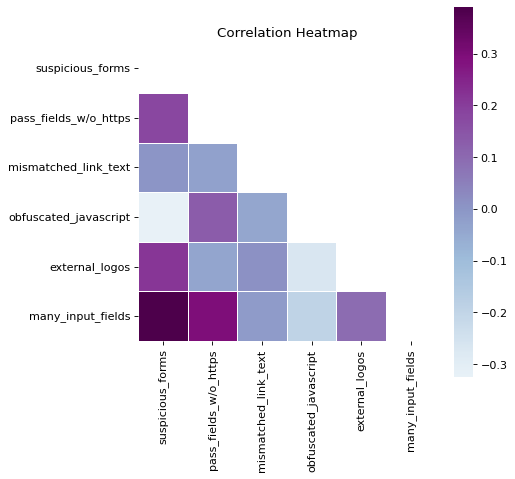

In [ ]:
fig = plt.figure(figsize=(6, 6), dpi=80)

corr_df = df.drop('label', axis=1)

corr_df.columns = [
    'suspicious_forms',
    'pass_fields_w/o_https',
    'mismatched_link_text',
    'obfuscated_javascript',
    'external_logos',
    'many_input_fields',
]

corr_matrix = corr_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='BuPu', robust=True, center=0,
            square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X, y)

print("LR bias:", float(lr.intercept_[0]))
print("LR weights:", lr.coef_[0].tolist())

# Estimate overall accuracy
print("LR CV accuracy:", cross_val_score(lr, X, y, cv=5).mean())

LR bias: -2.235936480000692
LR weights: [-1.022233316234737, 2.750549543983194, -1.9621860261613944, 3.2910815648312606, -0.5533334049667388, -0.01704486611927024]
LR CV accuracy: 0.7846203778708987


### Export Data

In [ ]:
weights = lr.coef_[0].tolist()        # 6 numbers
bias    = float(lr.intercept_[0])     # scalar

with open("static-content-detector-lr.json", "w") as f:
    json.dump({"bias": bias, "weights": weights}, f, indent=2)

## ROC

In [ ]:
p, r, th = precision_recall_curve(y, lr.predict_proba(X)[:,1])

y_pred_proba = lr.predict_proba(X)[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

### Best threshould

In [ ]:
# Find the best threshold based on the optimal point on the ROC curve (e.g., Youden's index)
optimal_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[optimal_idx]

print(f"Best Threshold: {best_threshold}")

Best Threshold: 0.34706054847207396


### Curve

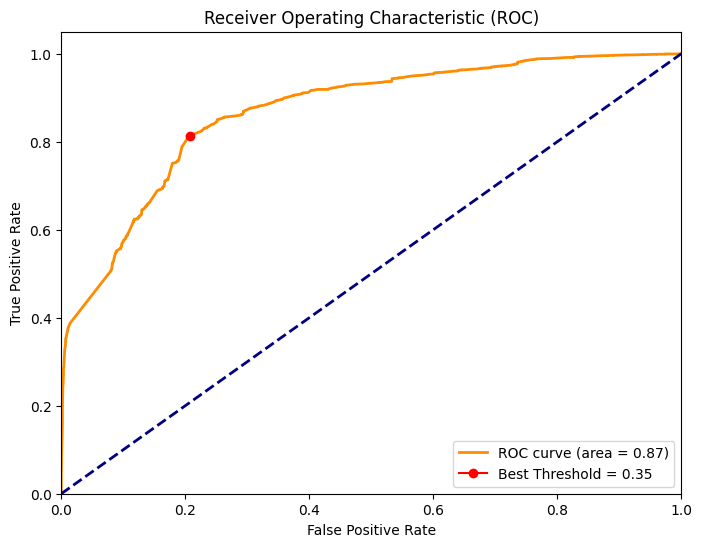

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Best Threshold = {best_threshold:.2f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()